In [2]:
# imports

import pickle
import pandas as pd
import numpy as np
import re
import spacy
import gensim
import gensim.corpora as corpora
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/home/yew/LDAproject/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
# load data

# cleaned df
with open("../../Data/df_clean.pkl", "rb") as f:
    df = pickle.load(f)
    f.close()
    
# taxonomy info
taxon_info = pd.read_csv("../../Data/taxonomy_info.csv", low_memory=False)

# load trained model
with open("../../Data/comb_global/model_17.pkl", "rb") as f:
    model = pickle.load(f)
    f.close()
    
# dictionary
dic = corpora.Dictionary.load("../../Data/comb_global/dic.dict")

# bigram model
bigram_mod = Phrases.load("../../Data/comb_global/bigram_mod.pkl")

In [3]:
df

Index(['assessmentId', 'internalTaxonId', 'scientificName', 'redlistCategory',
       'redlistCriteria', 'yearPublished', 'assessmentDate', 'criteriaVersion',
       'language', 'rationale', 'habitat', 'threats', 'population',
       'populationTrend', 'range', 'useTrade', 'systems',
       'conservationActions', 'realm', 'yearLastSeen', 'possiblyExtinct',
       'possiblyExtinctInTheWild', 'scopes'],
      dtype='object')

In [4]:
print(len(df.rationale))
print(len(df.habitat))
print(len(df.threats))
print(len(df.population))
print(len(df.range))
print(len(df.useTrade))
print(len(df.conservationActions))

111009
111009
111009
111009
111009
111009
111009


In [55]:
# select only taxonid and class_name
taxon_info = taxon_info[['taxonid', 'class_name']]
taxon_info = taxon_info.rename(columns={"taxonid": "internalTaxonId"})

# merge df with taxon_info
df = df.merge(taxon_info[['internalTaxonId', 'class_name']])

In [76]:
# prep corpus for model application

rat = df.rationale.values.tolist()
hab = df.habitat.values.tolist()
thr = df.threats.values.tolist()
pop = df.population.values.tolist()
ran = df.range.values.tolist()
use = df.useTrade.values.tolist()
con = df.conservationActions.values.tolist()

# load small sized english vocab
nlp = spacy.load('en_core_web_sm')

# add stopwords to spacy
nlp.Defaults.stop_words |= {"north", "northern", "northward", "south", "southern", "southward", "east", "eastern", "eastward", "west", "western", "westward", "northeast", "northeastern", "northwest", "northwestern", "southeast", "southeastern", "southwest", "southwestern", "centre", "central", "center", "upper", "lower", "high", "low"} | {"january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december", "day", "night", "week", "month", "year"} | {"situ", "appendix", "cite", "annex", "need", "book", "find"}

for word in nlp.Defaults.stop_words:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True
    
def bow_transform(corpus):
    """
    Function transforms corpus from text format into bag of words format
    """
    # generator of corpus
    gen = nlp.pipe(corpus, n_process = 7, batch_size = 800, disable = ["parser", "ner"])
    # tokenise corpus
    tokens = []
    for doc in gen:
        tokens.append([(tok.lemma_) for tok in doc if not tok.is_stop and not tok.is_punct and tok.tag_ != 'NNP' and tok.tag_ != 'NNPS' and tok.tag_ != 'VBG' and tok.tag_ != '_SP'])
    # apply bigram model
    tokens_2 = bigram_mod[tokens]
    # convert to bag of words corpus
    bow_corpus = [dic.doc2bow(doc) for doc in tokens_2]
    return bow_corpus

# transform individual assessment sections into bow format
rat_subcorpus = bow_transform(rat)
hab_subcorpus = bow_transform(hab)
thr_subcorpus = bow_transform(thr)
pop_subcorpus = bow_transform(pop)
ran_subcorpus = bow_transform(ran)
use_subcorpus = bow_transform(use)
con_subcorpus = bow_transform(con)

In [78]:
print(len(rat_subcorpus))

110934


## topic composition extraction

In [79]:
def topics_to_df(topics, num_topics):
    """
    Function converts the topic composition of documents to a dataframe
    """
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

def get_doc_topic_comp(corpus):
    """
    Function applies model to produce list of topic composition for each document
    """
    topic_comp = [model[corpus[i]] for i in range(len(corpus))]
    # generate dataframe of document topic composition
    doc_topic_comp = pd.concat([topics_to_df(topics, 17) for topics in topic_comp]).reset_index(drop = True).fillna(0)
    return doc_topic_comp

### get topic composition for each assessment section and save

In [80]:
rat_topic_comp = get_doc_topic_comp(rat_subcorpus)
rat_topic_comp = rat_topic_comp.add_suffix('_rat')

In [81]:
len(rat_topic_comp)

110934

In [82]:
with open("../../Data/comb_global/rat_topic_comp.pkl", "wb") as f:
    pickle.dump(rat_topic_comp, f)
    f.close()

In [83]:
hab_topic_comp = get_doc_topic_comp(hab_subcorpus)
hab_topic_comp = hab_topic_comp.add_suffix('_hab')

with open("../../Data/comb_global/hab_topic_comp.pkl", "wb") as f:
    pickle.dump(hab_topic_comp, f)
    f.close()

In [86]:
len(hab_topic_comp)

110934

In [84]:
thr_topic_comp = get_doc_topic_comp(thr_subcorpus)
thr_topic_comp = thr_topic_comp.add_suffix('_thr')

with open("../../Data/comb_global/thr_topic_comp.pkl", "wb") as f:
    pickle.dump(thr_topic_comp, f)
    f.close()

In [87]:
len(thr_topic_comp)

110934

In [85]:
pop_topic_comp = get_doc_topic_comp(pop_subcorpus)
pop_topic_comp = pop_topic_comp.add_suffix('_pop')

with open("../../Data/comb_global/pop_topic_comp.pkl", "wb") as f:
    pickle.dump(pop_topic_comp, f)
    f.close()

In [88]:
len(pop_topic_comp)

110934

In [89]:
ran_topic_comp = get_doc_topic_comp(ran_subcorpus)
ran_topic_comp = ran_topic_comp.add_suffix('_ran')

with open("../../Data/comb_global/ran_topic_comp.pkl", "wb") as f:
    pickle.dump(ran_topic_comp, f)
    f.close()

In [90]:
len(ran_topic_comp)

110934

In [91]:
use_topic_comp = get_doc_topic_comp(use_subcorpus)
use_topic_comp = use_topic_comp.add_suffix('_use')

with open("../../Data/comb_global/use_topic_comp.pkl", "wb") as f:
    pickle.dump(use_topic_comp, f)
    f.close()

In [92]:
len(use_topic_comp)

110934

In [94]:
con_topic_comp = get_doc_topic_comp(con_subcorpus)
con_topic_comp = con_topic_comp.add_suffix('_con')

with open("../../Data/comb_global/con_topic_comp.pkl", "wb") as f:
    pickle.dump(con_topic_comp, f)
    f.close()

In [95]:
len(con_topic_comp)

110934

## initialize dataframe for topic composition with corresponding red_list_cat, realm, systems and class_name


In [57]:
df_rl_r_s_c = pd.concat([df['internalTaxonId'], df['redlistCategory'], df['realm'], df['systems'], df['class_name']], axis = 1).reset_index(drop=True)
# rename columns
df_rl_r_s_c = df_rl_r_s_c.rename(columns={"redlistCategory":"Red_list_category", "realm":"Realm", "systems":"Systems", "class_name":"Class"})

In [58]:
df_rl_r_s_c

,internalTaxonId,Red_list_category,Realm,Systems,Class
0,10030,Near Threatened,NaN,Marine,CHONDRICHTHYES
1,132523146,Critically Endangered,Neotropical,Freshwater (=Inland waters),ACTINOPTERYGII
2,10267,Endangered,Oceanian,Terrestrial,GASTROPODA
3,10769,Vulnerable,Neotropical,Freshwater (=Inland waters),ACTINOPTERYGII
4,1078,Least Concern,Nearctic,Freshwater (=Inland waters),ACTINOPTERYGII
...,...,...,...,...,...
110929,133312385,Endangered,Neotropical,Terrestrial,MAGNOLIOPSIDA
110930,133320021,Critically Endangered,Neotropical,Terrestrial,MAGNOLIOPSIDA
110931,133321542,Vulnerable,Neotropical,Terrestrial,MAGNOLIOPSIDA
110932,167060,Least Concern,Indomalayan,Terrestrial|Freshwater (=Inland waters),INSECTA


## topic composition of each of the 7 assessment sections for each species

In [99]:
text_topic_comp = pd.concat([df_rl_r_s_c, rat_topic_comp, hab_topic_comp, thr_topic_comp, pop_topic_comp, ran_topic_comp, use_topic_comp, con_topic_comp], axis = 1).reset_index(drop = True)

In [101]:
# save text_topic_comp
# with open("../../Data/comb_global/text_topic_comp.pkl", "wb") as f:
#     pickle.dump(text_topic_comp, f)
#     f.close()

In [5]:
with open("../../Data/comb_global/text_topic_comp.pkl", "rb") as f:
    text_topic_comp = pickle.load(f)
    f.close()

In [6]:
# len(text_topic_comp)

110934

In [ ]:
# load text_topic_comp
# with open("../../Data/comb_global/text_topic_comp.pkl", "rb") as f:
#     text_topic_comp = pickle.load(f)
#     f.close()

In [5]:
# load assessment sections topic composition

with open("../../Data/comb_global/rat_topic_comp.pkl", "rb") as f:
    rat_topic_comp = pickle.load(f)
    f.close()
with open("../../Data/comb_global/hab_topic_comp.pkl", "rb") as f:
    hab_topic_comp = pickle.load(f)
    f.close()
with open("../../Data/comb_global/thr_topic_comp.pkl", "rb") as f:
    thr_topic_comp = pickle.load(f)
    f.close()
with open("../../Data/comb_global/pop_topic_comp.pkl", "rb") as f:
    pop_topic_comp = pickle.load(f)
    f.close()
with open("../../Data/comb_global/ran_topic_comp.pkl", "rb") as f:
    ran_topic_comp = pickle.load(f)
    f.close()
with open("../../Data/comb_global/use_topic_comp.pkl", "rb") as f:
    use_topic_comp = pickle.load(f)
    f.close()
with open("../../Data/comb_global/con_topic_comp.pkl", "rb") as f:
    con_topic_comp = pickle.load(f)
    f.close()

In [6]:
# aggregate topic composition

rat_topic_comp.columns = rat_topic_comp.columns.str.rstrip("_rat")
hab_topic_comp.columns = hab_topic_comp.columns.str.rstrip("_hab")
thr_topic_comp.columns = thr_topic_comp.columns.str.rstrip("_thr")
pop_topic_comp.columns = pop_topic_comp.columns.str.rstrip("_pop")
ran_topic_comp.columns = ran_topic_comp.columns.str.rstrip("_ran")
use_topic_comp.columns = use_topic_comp.columns.str.rstrip("_use")
con_topic_comp.columns = con_topic_comp.columns.str.rstrip("_con")

In [7]:
frames = [rat_topic_comp, hab_topic_comp, thr_topic_comp, pop_topic_comp, ran_topic_comp, use_topic_comp, con_topic_comp]

In [8]:
comb_topic_comp = pd.concat(frames, ignore_index = True)

In [9]:
comb_topic_comp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.000000,0.250339,0.000000,0.000000,0.000000,0.000000,0.000000,0.340183,0.313403,0.080781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.482061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.444409,0.000000,0.000000
2,0.168856,0.000000,0.000000,0.000000,0.305164,0.279086,0.000000,0.084013,0.000000,0.000000,0.000000,0.000000,0.146838,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.774625,0.000000,0.000000,0.000000,0.190080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.292992,0.000000,0.000000,0.247299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.416365,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776533,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.271709,0.181273,0.000000,0.000000,0.495546
776534,0.000000,0.000000,0.000000,0.000000,0.236637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.343325,0.000000,0.093358,0.294816
776535,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.843136,0.000000,0.000000,0.000000
776536,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.350446,0.551514


In [10]:
# rename columns to topic names
comb_topic_comp.columns = ['Spatial_data', 
        'Water_pollution_threat', 
        'Aquatic_ecology', 
        'Forest_loss', 
        'Monitoring_and_rewilding', 
        'Range_occurrence_and_occupancy', 
        'Common_threats', 
        'Terrestrial_ecology', 
        'Marine_population_structure', 
        'Fisheries_threats', 
        'Threat_distribution', 
        'Forest_fragmentation', 
        'Habitat_loss', 
        'Area_based_protection', 
        'Assessment_criteria', 
        'Population_dynamics', 
        'Conservation_actions']

In [11]:
# save comb_topic_comp
with open("../../Data/comb_global/comb_topic_comp.pkl", "wb") as f:
    pickle.dump(comb_topic_comp, f)
    f.close()

## Compare generality vs specificity

In [3]:
# open comb_topic_comp
with open("../../Data/comb_global/comb_topic_comp.pkl", "rb") as f:
    comb_topic_comp = pickle.load(f)
    f.close()

In [12]:
comb_topic_comp

,Spatial_data,Water_pollution_threat,Aquatic_ecology,Forest_loss,Monitoring_and_rewilding,Range_occurrence_and_occupancy,Common_threats,Forest_ecosystem,Marine_population_structure,Fisheries_threats,Threat_distribution,Forest_fragmentation,Habitat_loss,Area_based_protection,Assessment_criteria,Population_dynamics,Conservation_actions
0,0.000000,0.000000,0.250339,0.000000,0.000000,0.000000,0.000000,0.000000,0.340183,0.313403,0.080781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.482061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.444409,0.000000,0.000000
2,0.168856,0.000000,0.000000,0.000000,0.305164,0.279086,0.000000,0.084013,0.000000,0.000000,0.000000,0.000000,0.146838,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.774625,0.000000,0.000000,0.000000,0.190080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.292992,0.000000,0.000000,0.247299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.416365,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776533,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.271709,0.181273,0.000000,0.000000,0.495546
776534,0.000000,0.000000,0.000000,0.000000,0.236637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.343325,0.000000,0.093358,0.294816
776535,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.843136,0.000000,0.000000,0.000000
776536,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.350446,0.551514


In [13]:
# extract max weight in each document
max_weight = comb_topic_comp.max(axis=1)

In [14]:
# extract the topic that has the max weight in each document
top_topic = comb_topic_comp.idxmax(axis=1)

In [15]:
# create dataframe of top topic and each corresponding weight for each document
max_frame = {'Top_topic':top_topic, 'Weight':max_weight}
max_weight_topics = pd.DataFrame(max_frame)

In [16]:
max_weight_topics

,Top_topic,Weight
0,Marine_population_structure,0.340183
1,Range_occurrence_and_occupancy,0.482061
2,Monitoring_and_rewilding,0.305164
3,Water_pollution_threat,0.774625
4,Population_dynamics,0.416365
...,...,...
776533,Conservation_actions,0.495546
776534,Area_based_protection,0.343325
776535,Area_based_protection,0.843136
776536,Conservation_actions,0.551514


In [30]:
# group max_weight_topics by topics and calculate mean
topic_weights = max_weight_topics.groupby('Top_topic').mean()

In [31]:
index_order = [
    'Forest_loss',
    'Water_pollution_threat',
    'Habitat_loss',
    'Forest_fragmentation',
    'Threat_distribution',
    'Common_threats',
    'Population_dynamics',
    'Assessment_criteria',
    'Marine_population_structure',
    'Terrestrial_ecology',
    'Aquatic_ecology',
    'Fisheries_threats',
    'Range_occurrence_and_occupancy',
    'Spatial_data',
    'Conservation_actions',
    'Area_based_protection',
    'Monitoring_and_rewilding']

In [32]:
topic_weights = topic_weights.reindex(index_order)

In [33]:
# create dataframe for weights of topics when they are not the top topic for a document
weight_not_top_topic = pd.DataFrame(comb_topic_comp.sum(axis=0).reindex(index_order) - max_weight_topics.groupby('Top_topic').sum().reindex(index_order)['Weight'])

In [34]:
# calculate mean for weights of topics when they are not top topics
mean_weight_not_top_topic = weight_not_top_topic/pd.DataFrame(comb_topic_comp.count(axis=0).reindex(index_order) - max_weight_topics.groupby('Top_topic').count().reindex(index_order)['Weight'])

In [35]:
# add not top topic weights to weights dataframe
topic_weights['Mean_not_top'] = mean_weight_not_top_topic

In [36]:
topic_weights = topic_weights.reset_index()

In [37]:
topic_weights.rename(columns = {'Top_topic':'Topic', 'Weight':'Mean_top'}, inplace = True)

In [38]:
topic_weights

,Topic,Mean_top,Mean_not_top
0,Forest_loss,0.591165,0.028923
1,Water_pollution_threat,0.568921,0.026913
2,Habitat_loss,0.547027,0.034820
3,Forest_fragmentation,0.510694,0.022985
4,Threat_distribution,0.646477,0.030643
5,Common_threats,0.595537,0.034644
6,Population_dynamics,0.687019,0.028123
7,Assessment_criteria,0.570814,0.026729
8,Marine_population_structure,0.558805,0.024185
9,Forest_ecosystem,0.701199,0.031007


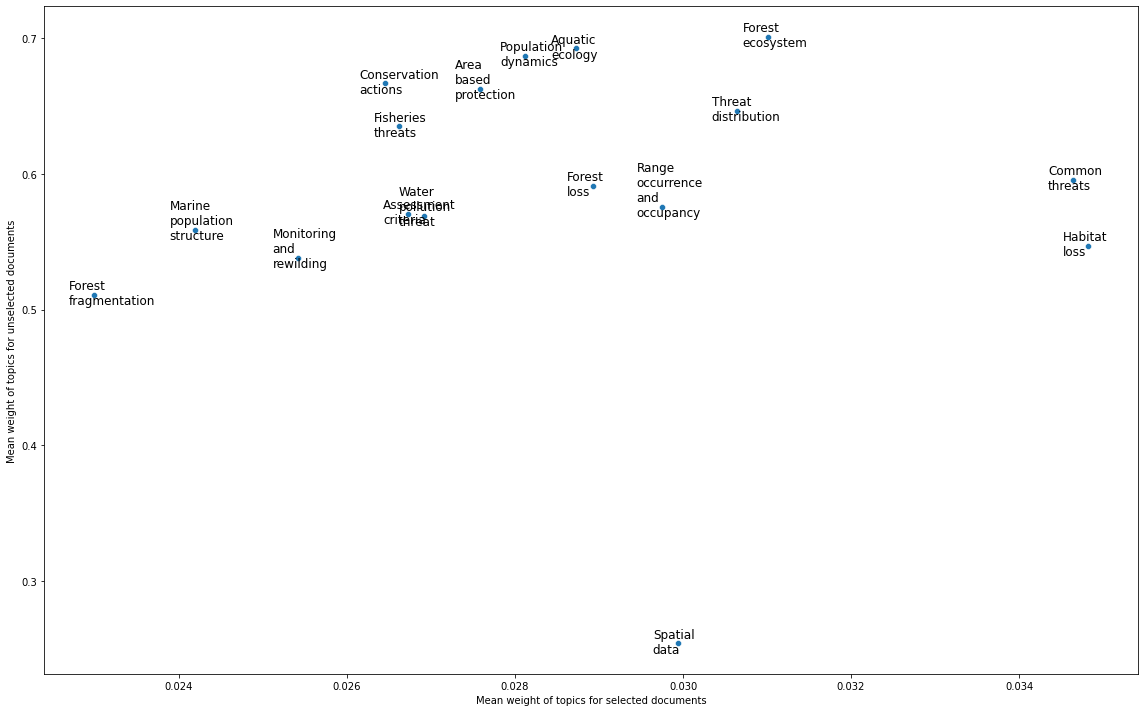

In [39]:
fig = plt.figure(figsize=(16,10)) # figure dimensions
# sns.set_context('notebook', font_scale=1.5) # context of plot and font scale
g = sns.scatterplot(data = topic_weights,
                x = 'Mean_not_top',
                y = 'Mean_top')
for i in range(len(topic_weights)):
    plt.text(x = topic_weights.Mean_not_top[i]-0.0003,
             y = topic_weights.Mean_top[i]-0.007,
             s = re.sub(r'\_', '\n',topic_weights.Topic[i]),
             fontdict = dict(color = 'black', size = 12))

g.set(xlabel = 'Mean weight of topics for selected documents',
      ylabel = 'Mean weight of topics for unselected documents')
plt.tight_layout()

In [40]:
fig.savefig("../../Data/comb_global/gen_vs_spe.svg", transparent = False)
plt.close('all')

## Plot probability distribution of topics from assessment topic composition

In [41]:
# load comb_topic_comp
with open("../../Data/comb_global/comb_topic_comp.pkl", "rb") as f:
    comb_topic_comp = pickle.load(f)
    f.close()

In [42]:
# melt comb_topic_comp_norm from wide to long format
top_prob_freq = pd.melt(comb_topic_comp.reset_index(), id_vars='index', var_name='Topic', value_name="Probability")

In [43]:
top_prob_freq

,index,Topic,Probability
0,0,Spatial_data,0.000000
1,1,Spatial_data,0.000000
2,2,Spatial_data,0.168856
3,3,Spatial_data,0.000000
4,4,Spatial_data,0.000000
...,...,...,...
13201141,776533,Conservation_actions,0.495546
13201142,776534,Conservation_actions,0.294816
13201143,776535,Conservation_actions,0.000000
13201144,776536,Conservation_actions,0.551514


In [44]:
# plot all topics together
sns.set(rc={"figure.figsize":(16,6)})
sns.set_style('whitegrid')
g = sns.kdeplot(data=top_prob_freq, x='Probability', hue='Topic', cut = 0)
g.set(xticks=np.arange(0,1,step=0.05))
g.set(xlabel = 'Topic Probability', ylabel = 'Probability Density')
plt.xlim(0,1)
plt.axvline(x=1/17, lw = 0.7, color = 'red')
# plt.show()
plt.savefig("../../Data/comb_global/comb_kde.svg")
plt.close('all')

In [76]:
1/17

0.058823529411764705

Using the average probability of topics (1/17) as a cutoff, topic probabilities below 1/17 will not be representative of a document.

In [45]:
# change all probabilities below 1/17 to 0
for i in frames:
    for j in range(17):
        i[str(j)] = i[str(j)].mask(i[str(j)] < 1/17, 0)

In [46]:
def tally_prob(row):
    """
    Function tallies and normalises the probability of the aggregated topic composition
    """
    row = row/round(row.sum())
    return row

In [47]:
# combined topic composition of 7 text summaries for each species
comb_topic_comp = rat_topic_comp + hab_topic_comp + thr_topic_comp + pop_topic_comp + ran_topic_comp + use_topic_comp + con_topic_comp

In [48]:
comb_topic_comp.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
count,110934.000000,110934.000000,110934.000000,110934.000000,110934.000000,110934.000000,110934.000000,110934.000000,110934.000000,110934.000000,110934.000000,110934.000000,110934.000000,110934.000000,110934.000000,110934.000000,110934.000000
mean,0.671805,0.264591,0.398091,0.318251,0.212825,0.329028,0.474927,0.568369,0.209047,0.350638,0.348482,0.161361,0.521483,0.379917,0.253067,0.316206,0.361044
std,0.506595,0.310663,0.484826,0.383017,0.272500,0.369381,0.470532,0.453224,0.298976,0.401520,0.386699,0.219354,0.453723,0.376714,0.310557,0.416534,0.341850
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.294118,0.000000,0.058824,0.000000,0.000000,0.058824,0.075445,0.167682,0.000000,0.058824,0.058824,0.000000,0.210727,0.058824,0.000000,0.000000,0.058824
50%,0.588539,0.176471,0.294118,0.235294,0.117647,0.270934,0.352941,0.520707,0.058824,0.292396,0.240047,0.058824,0.410640,0.294118,0.176471,0.176471,0.294118
75%,0.950143,0.352941,0.567284,0.411765,0.310881,0.428966,0.756153,0.895423,0.294118,0.501367,0.475513,0.294118,0.764705,0.599294,0.352941,0.411765,0.579065
max,3.481890,2.732291,3.513417,3.779053,3.494759,3.164735,3.326076,3.178177,2.862402,4.167273,2.867507,2.902649,3.407577,2.935387,2.837816,2.342668,3.647015


In [49]:
comb_topic_comp # sum of topic composition of all sections of assessment

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.000000,1.354979,0.000000,0.080525,0.000000,0.384140,0.000000,1.255466,2.360046,0.402522,0.000000,0.000000,0.000000,0.000000,0.358636,0.295097
1,0.357678,0.170231,1.452815,0.000000,0.346280,0.598541,0.686273,0.109431,0.000000,0.843135,0.000000,0.383580,0.000000,0.000000,0.444409,0.354685,0.456850
2,0.760576,0.761543,0.553107,0.154223,0.692171,1.161939,0.000000,0.084013,0.000000,0.000000,0.000000,0.067810,0.676248,0.000000,0.000000,0.811764,0.289380
3,0.599725,1.680506,0.778983,0.000000,0.448491,0.305154,0.000000,0.000000,0.000000,0.080016,0.297767,0.154788,0.529410,0.147486,0.238737,0.574836,0.276456
4,0.220567,0.470091,1.846811,0.058824,0.455331,0.351815,0.335308,0.058824,0.650738,0.058824,0.137707,0.058824,0.058824,0.058824,0.237575,0.584386,0.973261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110929,0.610191,0.000000,0.000000,0.739503,0.000000,0.309593,0.739710,0.000000,0.000000,0.000000,0.000000,0.000000,1.661948,0.181273,0.801336,0.329057,0.495546
110930,0.714745,0.000000,0.000000,1.355765,0.236637,0.876865,0.000000,0.811762,0.000000,0.544686,0.000000,0.000000,0.000000,0.343325,0.651148,0.387407,0.294816
110931,0.813224,0.000000,0.128686,1.039069,0.000000,0.000000,0.337746,0.799516,0.000000,0.698386,0.000000,0.573152,0.000000,0.843136,0.581575,0.278634,0.000000
110932,0.641683,0.058824,0.058824,0.058824,0.575122,0.058824,1.527421,0.924368,0.058824,0.058824,0.327473,0.058824,0.673386,0.058824,0.058824,0.409269,0.610337


In [50]:
# normalize total topic composition for each species
comb_topic_comp_norm = comb_topic_comp.apply(lambda x: tally_prob(x), axis = 1)

In [51]:
# rename columns to topic names
comb_topic_comp_norm.columns = ['Spatial_data', 
        'Water_pollution_threat', 
        'Aquatic_ecology', 
        'Forest_loss', 
        'Monitoring_and_rewilding', 
        'Range_occurrence_and_occupancy', 
        'Common_threats', 
        'Terrestrial_ecology', 
        'Marine_population_structure', 
        'Fisheries_threats', 
        'Threat_distribution', 
        'Forest_fragmentation', 
        'Habitat_loss', 
        'Area_based_protection', 
        'Assessment_criteria', 
        'Population_dynamics', 
        'Conservation_actions']

In [52]:
comb_topic_comp_norm

,Spatial_data,Water_pollution_threat,Aquatic_ecology,Forest_loss,Monitoring_and_rewilding,Range_occurrence_and_occupancy,Common_threats,Forest_ecosystem,Marine_population_structure,Fisheries_threats,Threat_distribution,Forest_fragmentation,Habitat_loss,Area_based_protection,Assessment_criteria,Population_dynamics,Conservation_actions
0,0.000000,0.000000,0.225830,0.000000,0.013421,0.000000,0.064023,0.000000,0.209244,0.393341,0.067087,0.000000,0.000000,0.000000,0.000000,0.059773,0.049183
1,0.059613,0.028372,0.242136,0.000000,0.057713,0.099757,0.114379,0.018238,0.000000,0.140522,0.000000,0.063930,0.000000,0.000000,0.074068,0.059114,0.076142
2,0.126763,0.126924,0.092184,0.025704,0.115362,0.193656,0.000000,0.014002,0.000000,0.000000,0.000000,0.011302,0.112708,0.000000,0.000000,0.135294,0.048230
3,0.099954,0.280084,0.129831,0.000000,0.074749,0.050859,0.000000,0.000000,0.000000,0.013336,0.049628,0.025798,0.088235,0.024581,0.039789,0.095806,0.046076
4,0.031510,0.067156,0.263830,0.008403,0.065047,0.050259,0.047901,0.008403,0.092963,0.008403,0.019672,0.008403,0.008403,0.008403,0.033939,0.083484,0.139037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110929,0.101698,0.000000,0.000000,0.123250,0.000000,0.051599,0.123285,0.000000,0.000000,0.000000,0.000000,0.000000,0.276991,0.030212,0.133556,0.054843,0.082591
110930,0.119124,0.000000,0.000000,0.225961,0.039440,0.146144,0.000000,0.135294,0.000000,0.090781,0.000000,0.000000,0.000000,0.057221,0.108525,0.064568,0.049136
110931,0.135537,0.000000,0.021448,0.173178,0.000000,0.000000,0.056291,0.133253,0.000000,0.116398,0.000000,0.095525,0.000000,0.140523,0.096929,0.046439,0.000000
110932,0.106947,0.009804,0.009804,0.009804,0.095854,0.009804,0.254570,0.154061,0.009804,0.009804,0.054579,0.009804,0.112231,0.009804,0.009804,0.068212,0.101723


In [59]:
# concat df_rl_r_s_c and comb_topic_comp_norm
df_topic_comp = pd.concat([df_rl_r_s_c, comb_topic_comp_norm], axis = 1)

# save df_topic_comp
with open("../../Data/comb_global/df_topic_comp.pkl", "wb") as f:
    pickle.dump(df_topic_comp, f)
    f.close()

In [60]:
df_topic_comp

,internalTaxonId,Red_list_category,Realm,Systems,Class,Spatial_data,Water_pollution_threat,Aquatic_ecology,Forest_loss,Monitoring_and_rewilding,...,Forest_ecosystem,Marine_population_structure,Fisheries_threats,Threat_distribution,Forest_fragmentation,Habitat_loss,Area_based_protection,Assessment_criteria,Population_dynamics,Conservation_actions
0,10030,Near Threatened,NaN,Marine,CHONDRICHTHYES,0.000000,0.000000,0.225830,0.000000,0.013421,...,0.000000,0.209244,0.393341,0.067087,0.000000,0.000000,0.000000,0.000000,0.059773,0.049183
1,132523146,Critically Endangered,Neotropical,Freshwater (=Inland waters),ACTINOPTERYGII,0.059613,0.028372,0.242136,0.000000,0.057713,...,0.018238,0.000000,0.140522,0.000000,0.063930,0.000000,0.000000,0.074068,0.059114,0.076142
2,10267,Endangered,Oceanian,Terrestrial,GASTROPODA,0.126763,0.126924,0.092184,0.025704,0.115362,...,0.014002,0.000000,0.000000,0.000000,0.011302,0.112708,0.000000,0.000000,0.135294,0.048230
3,10769,Vulnerable,Neotropical,Freshwater (=Inland waters),ACTINOPTERYGII,0.099954,0.280084,0.129831,0.000000,0.074749,...,0.000000,0.000000,0.013336,0.049628,0.025798,0.088235,0.024581,0.039789,0.095806,0.046076
4,1078,Least Concern,Nearctic,Freshwater (=Inland waters),ACTINOPTERYGII,0.031510,0.067156,0.263830,0.008403,0.065047,...,0.008403,0.092963,0.008403,0.019672,0.008403,0.008403,0.008403,0.033939,0.083484,0.139037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110929,133312385,Endangered,Neotropical,Terrestrial,MAGNOLIOPSIDA,0.101698,0.000000,0.000000,0.123250,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.276991,0.030212,0.133556,0.054843,0.082591
110930,133320021,Critically Endangered,Neotropical,Terrestrial,MAGNOLIOPSIDA,0.119124,0.000000,0.000000,0.225961,0.039440,...,0.135294,0.000000,0.090781,0.000000,0.000000,0.000000,0.057221,0.108525,0.064568,0.049136
110931,133321542,Vulnerable,Neotropical,Terrestrial,MAGNOLIOPSIDA,0.135537,0.000000,0.021448,0.173178,0.000000,...,0.133253,0.000000,0.116398,0.000000,0.095525,0.000000,0.140523,0.096929,0.046439,0.000000
110932,167060,Least Concern,Indomalayan,Terrestrial|Freshwater (=Inland waters),INSECTA,0.106947,0.009804,0.009804,0.009804,0.095854,...,0.154061,0.009804,0.009804,0.054579,0.009804,0.112231,0.009804,0.009804,0.068212,0.101723


## Plot heatmap of original columns

In [80]:
# load assessment sections topic composition

with open("../../Data/comb_global/rat_topic_comp.pkl", "rb") as f:
    rat_topic_comp = pickle.load(f)
    f.close()
with open("../../Data/comb_global/hab_topic_comp.pkl", "rb") as f:
    hab_topic_comp = pickle.load(f)
    f.close()
with open("../../Data/comb_global/thr_topic_comp.pkl", "rb") as f:
    thr_topic_comp = pickle.load(f)
    f.close()
with open("../../Data/comb_global/pop_topic_comp.pkl", "rb") as f:
    pop_topic_comp = pickle.load(f)
    f.close()
with open("../../Data/comb_global/ran_topic_comp.pkl", "rb") as f:
    ran_topic_comp = pickle.load(f)
    f.close()
with open("../../Data/comb_global/use_topic_comp.pkl", "rb") as f:
    use_topic_comp = pickle.load(f)
    f.close()
with open("../../Data/comb_global/con_topic_comp.pkl", "rb") as f:
    con_topic_comp = pickle.load(f)
    f.close()

In [61]:
# aggregate topic composition

rat_topic_comp.columns = rat_topic_comp.columns.str.rstrip("_rat")
hab_topic_comp.columns = hab_topic_comp.columns.str.rstrip("_hab")
thr_topic_comp.columns = thr_topic_comp.columns.str.rstrip("_thr")
pop_topic_comp.columns = pop_topic_comp.columns.str.rstrip("_pop")
ran_topic_comp.columns = ran_topic_comp.columns.str.rstrip("_ran")
use_topic_comp.columns = use_topic_comp.columns.str.rstrip("_use")
con_topic_comp.columns = con_topic_comp.columns.str.rstrip("_con")

In [62]:
rat_topic_comp.mean().to_frame().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.042966,0.02891,0.019098,0.034621,0.023518,0.091257,0.107092,0.020856,0.028114,0.018794,0.168871,0.042445,0.057458,0.029911,0.113116,0.086039,0.025235


In [63]:
frames = [rat_topic_comp, hab_topic_comp, thr_topic_comp, pop_topic_comp, ran_topic_comp, use_topic_comp, con_topic_comp]

In [64]:
for i in range(len(frames)):
    frames[i] = frames[i].mean().to_frame().T

In [65]:
section_topic_comp = pd.concat(frames, ignore_index = True)

In [66]:
section_topic_comp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.042966,0.028910,0.019098,0.034621,0.023518,0.091257,0.107092,0.020856,0.028114,0.018794,0.168871,0.042445,0.057458,0.029911,0.113116,0.086039,0.025235
1,0.032276,0.020454,0.213632,0.020490,0.014359,0.016820,0.017788,0.381744,0.016947,0.015577,0.014299,0.014547,0.037210,0.015212,0.013213,0.012747,0.015162
2,0.050754,0.127966,0.025078,0.150157,0.020050,0.019080,0.056849,0.026803,0.021851,0.041327,0.069513,0.021653,0.170121,0.028304,0.026389,0.014420,0.016466
3,0.078408,0.014086,0.026001,0.016469,0.038964,0.029225,0.204638,0.022660,0.082178,0.046892,0.018639,0.021375,0.049569,0.018484,0.036077,0.141917,0.018875
4,0.357321,0.016625,0.059524,0.015248,0.023641,0.125619,0.028418,0.056356,0.015181,0.012528,0.020245,0.014712,0.034409,0.029408,0.014328,0.013379,0.014926
5,0.058970,0.034909,0.035654,0.055946,0.031867,0.028682,0.040409,0.033569,0.029393,0.187085,0.032173,0.029729,0.122088,0.035489,0.031725,0.029654,0.029757
6,0.051109,0.021643,0.019104,0.025322,0.060426,0.018346,0.019734,0.026380,0.015382,0.028435,0.024742,0.016900,0.050627,0.223111,0.018219,0.018050,0.240624


In [111]:
section_topic_comp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Rationale,0.043642,0.029337,0.019644,0.035135,0.023955,0.091705,0.107835,0.021472,0.028558,0.019434,0.169485,0.042951,0.057919,0.030501,0.113592,0.086718,0.025972
Habitat,0.036988,0.025416,0.217562,0.025413,0.019330,0.021733,0.022770,0.383846,0.021923,0.020580,0.019253,0.019487,0.041472,0.020150,0.018175,0.017760,0.020162
Threats,0.054326,0.132187,0.029636,0.154124,0.024579,0.023523,0.060789,0.031325,0.026394,0.045941,0.072901,0.026209,0.173363,0.032648,0.030803,0.019012,0.021134
Population,0.083479,0.019686,0.031590,0.022078,0.044425,0.034702,0.207499,0.028234,0.087496,0.052070,0.024195,0.026938,0.054652,0.024003,0.041615,0.146271,0.024493
Range,0.360350,0.023150,0.065625,0.021832,0.030141,0.131453,0.034740,0.062152,0.021767,0.019123,0.026763,0.021305,0.040353,0.035672,0.020912,0.019982,0.021503
Use and trade,0.067087,0.043738,0.044553,0.064442,0.040776,0.037671,0.048936,0.042467,0.038374,0.193419,0.041050,0.038677,0.126431,0.044321,0.040639,0.038637,0.038743
Conservation actions,0.055541,0.026717,0.024212,0.030398,0.065393,0.023449,0.024754,0.031426,0.020497,0.033553,0.029757,0.021959,0.054732,0.226280,0.023248,0.023109,0.244693


In [67]:
section_topic_comp.index = ['Rationale', 'Habitat', 'Threats', 'Population', 'Range', 'Use and trade', 'Conservation actions']
section_topic_comp.index.rename('Text sections', inplace=True)

In [68]:
# rename columns to topic names
section_topic_comp.columns = ['Spatial_data', 
        'Water_pollution_threat', 
        'Aquatic_ecology', 
        'Forest_loss', 
        'Monitoring_and_rewilding', 
        'Range_occurrence_and_occupancy', 
        'Common_threats', 
        'Terrestrial_ecology', 
        'Marine_population_structure', 
        'Fisheries_threats', 
        'Threat_distribution', 
        'Forest_fragmentation', 
        'Habitat_loss', 
        'Area_based_protection', 
        'Assessment_criteria', 
        'Population_dynamics', 
        'Conservation_actions']

## Plot heatmap of Red List Categories

In [118]:
# load df_topic_comp
with open("../../Data/comb_global/df_topic_comp.pkl", "rb") as f:
    df_topic_comp = pickle.load(f)
    f.close()

In [69]:
# change low risk conservation dependent and low risk near threatened to near threatened, low risk least concern to least concern
df_topic_comp['Red_list_category'] = df_topic_comp['Red_list_category'].replace('Lower Risk/conservation dependent', 'Near Threatened')
df_topic_comp['Red_list_category'] = df_topic_comp['Red_list_category'].replace('Lower Risk/near threatened', 'Near Threatened')
df_topic_comp['Red_list_category'] = df_topic_comp['Red_list_category'].replace('Lower Risk/least concern', 'Least Concern')

In [70]:
# filter out regional assessments
df_no_reg_ext = df_topic_comp[(df_topic_comp.Red_list_category != 'Regionally Extinct')]

In [72]:
# group by red list category and calculate mean of topic composition for each category
red_list_topic = df_no_reg_ext.drop(columns=['internalTaxonId','Realm', 'Systems', 'Class']).groupby(['Red_list_category']).mean()
# reorder and sort index
index_order = ['Least Concern', 'Near Threatened', 'Vulnerable', 'Endangered', 'Critically Endangered', 'Extinct in the Wild', 'Extinct']
red_list_topic = red_list_topic.reindex(index_order)
red_list_topic.index.rename('Red list category', inplace=True)

## Plot heatmap of Systems

In [73]:
# replace Marine|Marine with Marine
df_topic_comp['Systems'] = df_topic_comp['Systems'].replace('Marine|Marine', 'Marine')
systems_topic = df_topic_comp

In [74]:
# group by systems and sum topic composition for each category
systems_topic = systems_topic.drop(columns=['internalTaxonId','Red_list_category', 'Realm', 'Class']).groupby(['Systems']).mean()
# reorder and sort index
index_order = ['Terrestrial', 'Freshwater (=Inland waters)', 'Marine', 'Terrestrial|Freshwater (=Inland waters)', 'Freshwater (=Inland waters)|Marine', 'Terrestrial|Marine', 'Terrestrial|Freshwater (=Inland waters)|Marine']
systems_topic = systems_topic.reindex(index_order)
systems_topic = systems_topic.rename(index={'Freshwater (=Inland waters)':'Freshwater', 'Terrestrial|Freshwater (=Inland waters)':'Terrestrial and Freshwater', 'Freshwater (=Inland waters)|Marine':'Freshwater and Marine', 'Terrestrial|Marine':'Terrestrial and Marine', 'Terrestrial|Freshwater (=Inland waters)|Marine':'All three'})

## Plot heatmap for classes containing more than 325 species

In [75]:
# group by class and sum topic composition for each category
class_topic = df_topic_comp.drop(columns=['internalTaxonId','Red_list_category', 'Realm', 'Systems']).groupby(['Class']).mean()
# class_topic_pct = class_topic/(df_topic_comp.drop(columns=['internalTaxonId','Red_list_category', 'Realm', 'Systems']).groupby(['Class']).count())

In [79]:
# select classes with less than 325 species
index = df_topic_comp.drop(columns=['internalTaxonId','Red_list_category', 'Realm', 'Systems'])['Class'].value_counts()[lambda x: x>325].index.tolist()
top_quart_class_topic = class_topic[class_topic.index.isin(index)]
top_quart_class_topic.columns = ['Spatial_data', 
        'Water_pollution_threat', 
        'Aquatic_ecology', 
        'Forest_loss', 
        'Monitoring_and_rewilding', 
        'Range_occurrence_and_occupancy', 
        'Common_threats', 
        'Terrestrial_ecology', 
        'Marine_population_structure', 
        'Fisheries_threats', 
        'Threat_distribution', 
        'Forest_fragmentation', 
        'Habitat_loss', 
        'Area_based_protection', 
        'Assessment_criteria', 
        'Population_dynamics', 
        'Conservation_actions']

In [77]:
top_quart_class_topic.index = top_quart_class_topic.index.str.capitalize()

In [83]:
# reorder columns
columns = [
    'Forest_loss',
    'Water_pollution_threat',
    'Habitat_loss',
    'Forest_fragmentation',
    'Threat_distribution',
    'Common_threats',
    'Population_dynamics',
    'Assessment_criteria',
    'Marine_population_structure',
    'Terrestrial_ecology',
    'Aquatic_ecology',
    'Fisheries_threats',
    'Range_occurrence_and_occupancy',
    'Spatial_data',
    'Conservation_actions',
    'Area_based_protection',
    'Monitoring_and_rewilding']

section_topic_comp = section_topic_comp.reindex(columns=columns)
red_list_topic = red_list_topic.reindex(columns=columns)
system_topic = systems_topic.reindex(columns=columns)
top_quart_class_topic = top_quart_class_topic.reindex(columns=columns)


In [100]:
# imports for dendrogram
from scipy.cluster.hierarchy import ward, dendrogram
import pylab

In [104]:
# load data for dendrogram
with open("../../Data/comb_global/model_15.pkl", "rb") as f:
    model_15 = pickle.load(f)
    f.close()

In [107]:
# calculate topic distance using jaccard

jac, annotation = model_15.diff(model_15, distance='jaccard', num_words=30)
jac_matrix = ward(jac)

/home/yew/LDAproject/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


## Try plotting all heatmaps together with dendrogram

/tmp/ipykernel_148285/136900683.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


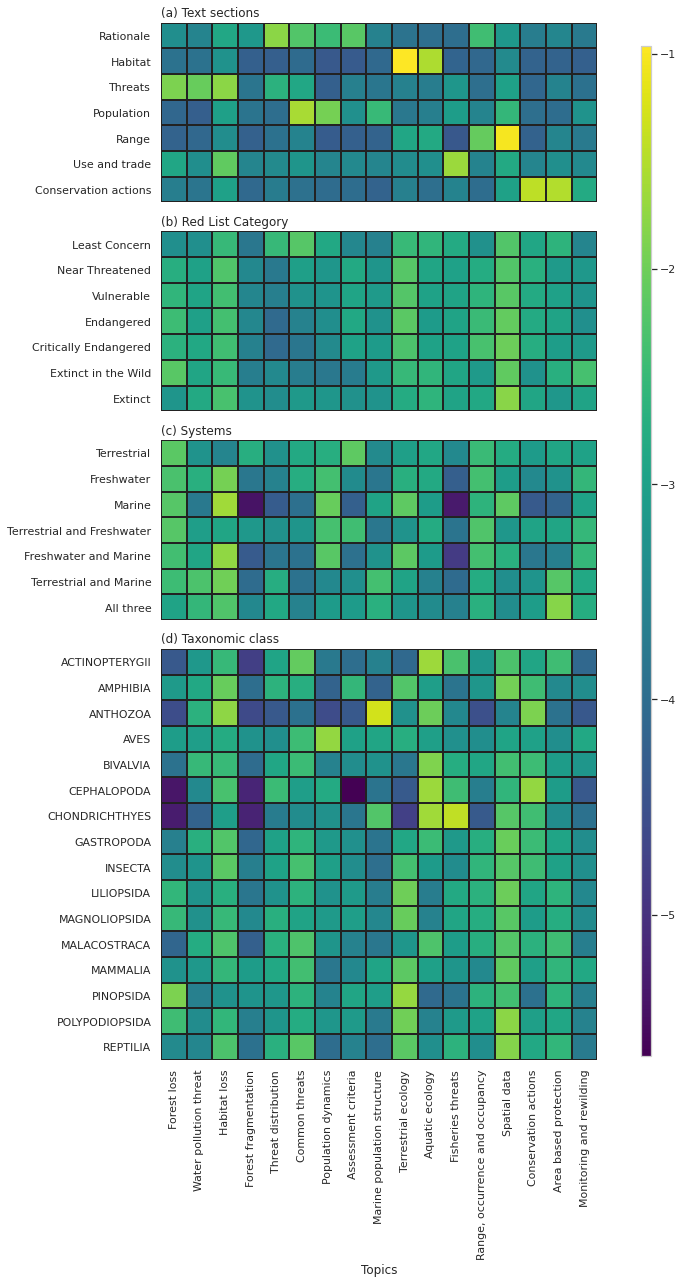

In [178]:
a = section_topic_comp.loc[section_topic_comp.idxmax(axis=1).index]
b = red_list_topic.loc[red_list_topic.idxmax(axis=1).index]
c = systems_topic.loc[systems_topic.idxmax(axis=1).index]
d = top_quart_class_topic.loc[top_quart_class_topic.idxmax(axis=1).index]

fig, ax = plt.subplots(4, 1,
                       figsize=(13,18),
                       sharex=True,
                       gridspec_kw={'height_ratios': [len(a),len(b),len(c),len(d)]},
                      )  

# dendrogram(jac_matrix, orientation='top', labels=None, ax=ax[0])

sns.heatmap(np.log(a),
            cmap="viridis",  # Choose a squential color
            annot=False,
#                 annot=jb_labels, # Label the maximum value
#             annot_kws={'fontsize':11},  # Reduce size of label to fit
#                 ylabel = False,
            cbar = False,
#             fmt='',          # Interpret labels as strings
            square=True,     # Force square cells
            vmax=max(np.log(a).max()),         # Ensure same 
            vmin=min(np.log(d).min()),          # color scale
            linewidth=0.01,  # Add gridlines
            linecolor="#222",# Adjust gridline color
            ax=ax[0],        # Arrange in subplot
           )
sns.heatmap(np.log(b),
            cmap="viridis",  # Choose a squential color
            annot=False,
#                 annot=jb_labels, # Label the maximum value
#             annot_kws={'fontsize':11},  # Reduce size of label to fit
#                 ylabel = False,
            cbar = False,
#             fmt='',          # Interpret labels as strings
            square=True,     # Force square cells
            vmax=max(np.log(a).max()),         # Ensure same 
            vmin=min(np.log(d).min()),          # color scale
            linewidth=0.01,  # Add gridlines
            linecolor="#222",# Adjust gridline color
            ax=ax[1],        # Arrange in subplot
           )
sns.heatmap(np.log(c),
            cmap="viridis",  # Choose a squential color
            annot=False,
#                 annot=jb_labels, # Label the maximum value
#             annot_kws={'fontsize':11},  # Reduce size of label to fit
#                 ylabel = False,
            cbar = False,
#             fmt='',          # Interpret labels as strings
            square=True,     # Force square cells
            vmax=max(np.log(a).max()),         # Ensure same 
            vmin=min(np.log(d).min()),          # color scale
            linewidth=0.01,  # Add gridlines
            linecolor="#222",# Adjust gridline color
            ax=ax[2],        # Arrange in subplot
           )
sns.heatmap(np.log(d),
            cmap="viridis",  # Choose a squential color
            annot=False,
#                 annot=jb_labels, # Label the maximum value
#             annot_kws={'fontsize':11},  # Reduce size of label to fit
#                 ylabel = False,
            cbar = False,
#             fmt='',          # Interpret labels as strings
            square=True,     # Force square cells
            vmax=max(np.log(a).max()),         # Ensure same 
            vmin=min(np.log(d).min()),          # color scale
            linewidth=0.01,  # Add gridlines
            linecolor="#222",# Adjust gridline color
            ax=ax[3],        # Arrange in subplot
           )

fig.colorbar(ax[0].collections[0], cax=fig.add_axes([0.78,0.18,0.01,0.78]))


ax[0].set_title('(a) Text sections', loc = 'left')
ax[1].set_title('(b) Red List Category', loc = 'left')
ax[2].set_title('(c) Systems', loc = 'left')
ax[3].set_title('(d) Taxonomic class', loc = 'left')
for i in range(4):
    ax[i].set_ylabel('')
    ax[i].tick_params(left=False, bottom=False)

ax[3].set_xlabel('Topics')
ax[3].set_xticklabels([
    'Forest loss',
    'Water pollution threat',
    'Habitat loss',
    'Forest fragmentation',
    'Threat distribution',
    'Common threats',
    'Population dynamics',
    'Assessment criteria',
    'Marine population structure',
    'Terrestrial ecology',
    'Aquatic ecology',
    'Fisheries threats',
    'Range, occurrence and occupancy',
    'Spatial data',
    'Conservation actions',
    'Area based protection',
    'Monitoring and rewilding'])

plt.tight_layout()

dend = dendrogram(jac_matrix, orientation='top', labels=None, 
#                  ax=ax[0]
                 )

hm_a = sns.heatmap(np.log(a),
            cmap="viridis",  # Choose a squential color
            annot=False,
#                 annot=jb_labels, # Label the maximum value
#             annot_kws={'fontsize':11},  # Reduce size of label to fitm
#                 ylabel = False,
            cbar = False,
#             fmt='',          # Interpret labels as strings
            square=True,     # Force square cells
            vmax=max(np.log(a).max()),         # Ensure same 
            vmin=min(np.log(d).min()),          # color scale
            linewidth=0.01,  # Add gridlines
            linecolor="#222",# Adjust gridline color
#             ax=ax[1],        # Arrange in subplot
           )
# hm_b = sns.heatmap(np.log(b),
#             cmap="viridis",  # Choose a squential color
#             annot=False,
# #                 annot=jb_labels, # Label the maximum value
# #             annot_kws={'fontsize':11},  # Reduce size of label to fit
# #                 ylabel = False,
#             cbar = False,
# #             fmt='',          # Interpret labels as strings
#             square=True,     # Force square cells
#             vmax=max(np.log(a).max()),         # Ensure same 
#             vmin=min(np.log(d).min()),          # color scale
#             linewidth=0.01,  # Add gridlines
#             linecolor="#222",# Adjust gridline color
# #             ax=ax[2],        # Arrange in subplot
#            )
# hm_c = sns.heatmap(np.log(c),
#             cmap="viridis",  # Choose a squential color
#             annot=False,
# #                 annot=jb_labels, # Label the maximum value
# #             annot_kws={'fontsize':11},  # Reduce size of label to fit
# #                 ylabel = False,
#             cbar = False,
# #             fmt='',          # Interpret labels as strings
#             square=True,     # Force square cells
#             vmax=max(np.log(a).max()),         # Ensure same 
#             vmin=min(np.log(d).min()),          # color scale
#             linewidth=0.01,  # Add gridlines
#             linecolor="#222",# Adjust gridline color
# #             ax=ax[3],        # Arrange in subplot
#            )
# hm_d = sns.heatmap(np.log(d),
#             cmap="viridis",  # Choose a squential color
#             annot=False,
# #                 annot=jb_labels, # Label the maximum value
# #             annot_kws={'fontsize':11},  # Reduce size of label to fit
# #                 ylabel = False,
#             cbar = False,
# #             fmt='',          # Interpret labels as strings
#             square=True,     # Force square cells
#             vmax=max(np.log(a).max()),         # Ensure same 
#             vmin=min(np.log(d).min()),          # color scale
#             linewidth=0.01,  # Add gridlines
#             linecolor="#222",# Adjust gridline color
# #             ax=ax[4],        # Arrange in subplot
#            )


# Compute and plot dendrogram.
fig = pylab.figure()
axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
dend
axdendro.set_xticks([])
axdendro.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
# index = Z['leaves']
# D = D[index,:]
# D = D[:,index]
im = axmatrix.matshow(hm_a, aspect='auto', origin='lower')
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
pylab.colorbar(im, cax=axcolor)

# # Display and save figure.
# fig.show()
# fig.savefig('dendrogram.png')

In [179]:
fig.savefig("../../Data/comb_global/combined_hm.svg")
plt.close('all')

## try exporting json from pyldavis

In [1]:
import json

In [32]:
import numpy as np
from matplotlib.colors import hsv_to_rgb

In [34]:
V, H = np.mgrid[0:1:100j, 0:1:300j]
S = np.ones_like(V)
HSV = np.dstack((H,S,V))
RGB = hsv_to_rgb(HSV)

In [2]:
with open('../../Data/comb_global/vis_17.json') as f:
    data = f.read()

In [3]:
json_data = json.loads(data)

In [24]:
json_data['mdsDat']['topics']

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [4]:
import matplotlib.pyplot as plt

In [5]:
x_max = max(json_data['mdsDat']['x']) + (max(json_data['mdsDat']['x']) - min(json_data['mdsDat']['x'])) 
y_max = max(json_data['mdsDat']['y']) + (max(json_data['mdsDat']['y']) - min(json_data['mdsDat']['y'])) 
x_min = min(json_data['mdsDat']['x']) - (max(json_data['mdsDat']['x']) - min(json_data['mdsDat']['x'])) 
y_min = min(json_data['mdsDat']['y']) - (max(json_data['mdsDat']['y']) - min(json_data['mdsDat']['y']))

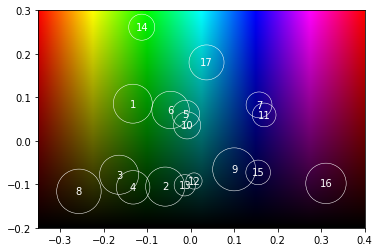

In [41]:
plt.axis([-0.35, 0.4, -0.2, 0.3])
plt.imshow(RGB, origin="lower", extent=[-0.35,0.4,-0.2,0.3], aspect=1)
for i in range(len(json_data['mdsDat']['x'])):
    circle = plt.Circle((json_data['mdsDat']['x'][i],json_data['mdsDat']['y'][i]), radius = json_data['mdsDat']['Freq'][i]/160, fill = False, lw = 0.5, color = 'white')
    plt.gca().add_artist(circle)
    label = plt.annotate(json_data['mdsDat']['topics'][i], xy=(json_data['mdsDat']['x'][i],json_data['mdsDat']['y'][i]), fontsize = 10, verticalalignment = 'center', horizontalalignment = 'center', color = 'white')

In [10]:
plt.show()

try flipping the hsv so dark color on top